In [1]:
# @title
### EP2 MAC0417 / MAC5768
################################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,               #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO                   #
# DESTE EP.                                                                    #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,                 #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM                        #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                                           #
#                                                                              #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS                      #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A                        #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E                      #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS                  #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                                         #
#                                                                              #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO                       #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR                           #
# DESONESTIDADE ACADÊMICA.                                                     #
#                                                                              #
#  Nome : Lucas Paiolla Forastiere                                             #
#  NUSP : 11221911                                                             #
#  Turma: MAC5768                                                              #
#  Prof.: Ronaldo Fumio Hashimoto                                              #
################################################################################

## Data Augmentation notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extra non "data science / image processing" libraries
from typing import Callable
from tqdm.notebook import tqdm

# Global variables
from global_variables import (
    METADATA_FILE
)

In [3]:
metadata = pd.read_csv(METADATA_FILE)
metadata

,file_path,height,width,channels,background,illumination,environment,objects_in_image_code,objects_in_image_numeric,label_code,label_numeric
0,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",phone,8
1,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",blackkc,1
2,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",bluebs,5
3,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",d20,4
4,data/blue_night_outside/bluebs-mic-phone.jpg,385,217,3,blue,night,outside,"['bluebs', 'mic', 'phone']","[5, 9, 8]",bluebs,5
...,...,...,...,...,...,...,...,...,...,...,...
1427,data/lightblue_night_inside/d6-mic-switch-blac...,385,217,3,lightblue,night,inside,"['d6', 'mic', 'switch', 'blackkc']","[3, 9, 0, 1]",blackkc,1
1428,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",watch,7
1429,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",brownbs,6
1430,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",d6,3


In [4]:
sample_img_path = metadata["file_path"].iloc[0]
sample_img = plt.imread(sample_img_path)[:, :, 0]

### Augmentation Functions

Here, we'll define functions that take a single image and return the augmented image.

Later we'll apply these functions to the images in the dataset.


In [5]:
def rescale_img(img: np.ndarray, range: tuple | None = None) -> np.ndarray:
    range = range or (0, 255)
    min, max = range

    std = (img - img.min()) / (img.max() - img.min())
    return std * (max - min) + min


def apply_func(img: np.ndarray, func: Callable, rescale: bool = True):
    vec_func = np.vectorize(func)
    new_img = vec_func(img)

    if rescale:
        new_img = rescale_img(new_img)
    return new_img.astype(np.uint8)


def convolve_image(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    m, n = kernel.shape
    image = np.pad(image, kernel.shape[0] // 2, mode="constant")
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    new_image = np.zeros((y, x))
    for i in range(y):
        for j in range(x):
            new_image[i][j] = np.sum(image[i : i + m, j : j + n] * kernel)
    return rescale_img(new_image)

In [6]:
def compare_images(
    img1: np.ndarray, augmented_img: np.ndarray, **kwargs
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(img1, cmap="gray")
    ax[1].imshow(augmented_img, cmap="gray")
    ax[0].axis("off")
    ax[1].axis("off")
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()

In [7]:
augmentation_functions = []

In [8]:
# Contrast Stretching
def contrast_stretching_(r, r1, s1, r2, s2):
    # line 1: zero to (r1, s1)
    if r <= r1:
        return s1 / r1 * r + 0
    # line 2: (r1, s1) to (r2, s2)
    if r <= r2:
        return (s2 - s1) / (r2 - r1) * (r - r1) + s1
    # line 3: (r2, s2) to (255, 255)
    return (255 - s2) / (255 - r2) * (r - r2) + s2


# these parameters give basically the same img.
# TODO: ask TA what values do we need to use
r1, s1, r2, s2 = 1, 0, 254, 255
contrast_stretching = lambda img: apply_func(
    img, lambda r: contrast_stretching_(r, r1, s1, r2, s2)
)
contrast_stretching.__name__ = "contrast_stretching"
augmentation_functions.append(contrast_stretching)

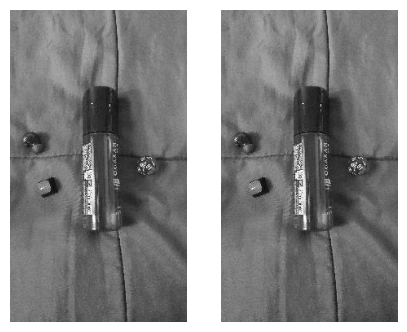

In [9]:
compare_images(sample_img, contrast_stretching(sample_img))

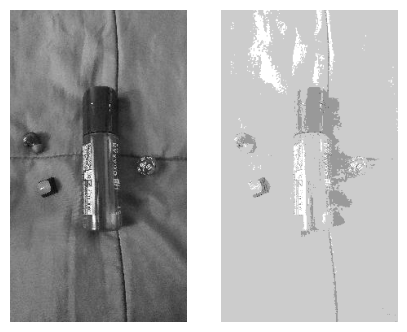

In [10]:
# Logarithmic Transformation
c = 1
log = lambda img: apply_func(img, lambda r: int(c * np.log(1 + r)))
log.__name__ = "log"
augmentation_functions.append(log)
compare_images(sample_img, log(sample_img))

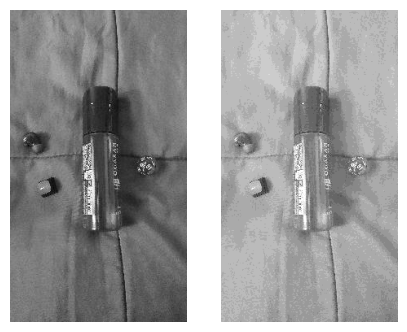

In [11]:
# Power-Law (Gamma) Transformation
gamma = 0.5
c = 1
power_law = lambda img: apply_func(img, lambda r: int(c * r**gamma))
power_law.__name__ = "power_law"
augmentation_functions.append(power_law)
compare_images(sample_img, power_law(sample_img))

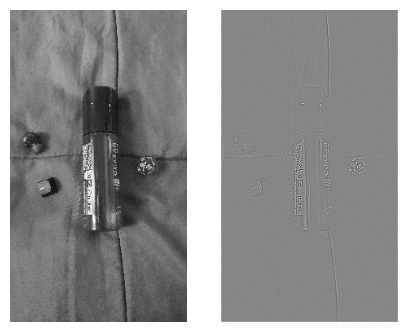

In [12]:
# Laplacian Kernel
laplacian_kernel = lambda img: convolve_image(
    img, np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
)
laplacian_kernel.__name__ = "laplacian_kernel"
augmentation_functions.append(laplacian_kernel)
compare_images(sample_img, laplacian_kernel(sample_img))

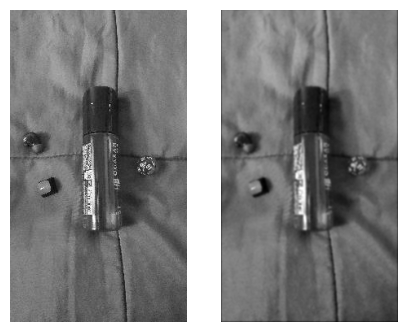

In [13]:
# Gaussian Kernel
gaussian_kernel = lambda img: convolve_image(
    img,
    np.array(
        [
            [1, 4, 6, 4, 1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4, 6, 4, 1],
        ]
    )
    / 256,
)
gaussian_kernel.__name__ = "gaussian_kernel"
augmentation_functions.append(gaussian_kernel)
compare_images(sample_img, gaussian_kernel(sample_img))

In [14]:
metadata["augmentation"] = "None"
metadata

,file_path,height,width,channels,background,illumination,environment,objects_in_image_code,objects_in_image_numeric,label_code,label_numeric,augmentation
0,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",phone,8,None
1,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",blackkc,1,None
2,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",bluebs,5,None
3,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",d20,4,None
4,data/blue_night_outside/bluebs-mic-phone.jpg,385,217,3,blue,night,outside,"['bluebs', 'mic', 'phone']","[5, 9, 8]",bluebs,5,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1427,data/lightblue_night_inside/d6-mic-switch-blac...,385,217,3,lightblue,night,inside,"['d6', 'mic', 'switch', 'blackkc']","[3, 9, 0, 1]",blackkc,1,None
1428,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",watch,7,None
1429,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",brownbs,6,None
1430,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",d6,3,None


In [15]:
originalGreyDataset = []
for idx, row in metadata.iterrows():
    img = plt.imread(row["file_path"])[:, :, 0]
    originalGreyDataset.append(img)

originalGreyDataset = np.array(originalGreyDataset)

In [16]:
new_dfs = []
new_datasets = []
for func in tqdm(augmentation_functions):
    augmented_df = metadata.copy()
    augmented_df["augmentation"] = func.__name__
    new_dfs.append(augmented_df)

    augmented_dataset = []
    for img in tqdm(originalGreyDataset, desc=func.__name__):
        augmented_dataset.append(func(img))
    augmented_dataset = np.array(augmented_dataset)
    new_datasets.append(augmented_dataset)


  0%|          | 0/5 [00:00<?, ?it/s]

contrast_stretching:   0%|          | 0/1432 [00:00<?, ?it/s]

log:   0%|          | 0/1432 [00:00<?, ?it/s]

power_law:   0%|          | 0/1432 [00:00<?, ?it/s]

laplacian_kernel:   0%|          | 0/1432 [00:00<?, ?it/s]

gaussian_kernel:   0%|          | 0/1432 [00:00<?, ?it/s]

In [17]:
augmentedDataset = np.concatenate([originalGreyDataset] + new_datasets).astype(np.uint8)

print(originalGreyDataset.shape)
print(augmentedDataset.shape)
augmented_metadata = pd.concat([metadata] + new_dfs).reset_index(drop=True)
augmented_metadata

(1432, 385, 217)
(8592, 385, 217)


,file_path,height,width,channels,background,illumination,environment,objects_in_image_code,objects_in_image_numeric,label_code,label_numeric,augmentation
0,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",phone,8,None
1,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",blackkc,1,None
2,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",bluebs,5,None
3,data/blue_night_outside/phone-blackkc-bluebs-d...,385,217,3,blue,night,outside,"['phone', 'blackkc', 'bluebs', 'd20']","[8, 1, 5, 4]",d20,4,None
4,data/blue_night_outside/bluebs-mic-phone.jpg,385,217,3,blue,night,outside,"['bluebs', 'mic', 'phone']","[5, 9, 8]",bluebs,5,None
...,...,...,...,...,...,...,...,...,...,...,...,...
8587,data/lightblue_night_inside/d6-mic-switch-blac...,385,217,3,lightblue,night,inside,"['d6', 'mic', 'switch', 'blackkc']","[3, 9, 0, 1]",blackkc,1,gaussian_kernel
8588,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",watch,7,gaussian_kernel
8589,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",brownbs,6,gaussian_kernel
8590,data/lightblue_night_inside/watch-brownbs-d6-b...,385,217,3,lightblue,night,inside,"['watch', 'brownbs', 'd6', 'bluebs']","[7, 6, 3, 5]",d6,3,gaussian_kernel


In [18]:
from pathlib import Path


augmentedDataset_path = Path("augmentedDataset.npy")
originalGreyDataset_path = Path("originalGreyDataset.npy")
augmented_metadata_path = Path("augmented_metadata.csv")

if augmentedDataset_path.exists():
    augmentedDataset_path.unlink()
if originalGreyDataset_path.exists():
    originalGreyDataset_path.unlink()
if augmented_metadata_path.exists():
    augmented_metadata_path.unlink()

augmentedDataset.tofile(augmentedDataset_path)
originalGreyDataset.tofile(originalGreyDataset_path)
augmented_metadata.to_csv(augmented_metadata_path, index=False)